In [1]:
# !yes | conda install pytorch torchvision -c pytorch
# !yes | conda install numpy
# !yes | conda install tqdm
# !yes | conda install matplotlib

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import init
from argparse import Namespace
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as FT

In [4]:
!nvidia-smi

Thu Dec 27 18:54:44 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 43%   60C    P8    19W / 250W |     22MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0  On |                  N/A |
| 46%   67C    P8    21W / 250W |     22MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
args = Namespace(
    n_batch=128,
    device='cuda:3'
)

In [6]:
train = CIFAR10(
    '.', 
    transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]), 
    download=True
)
train_dl = DataLoader(train, args.n_batch, shuffle=True, num_workers=4, drop_last=True)

Files already downloaded and verified


In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(8 * 8 * 16, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """[B x 3 x 32 x 32] => [B x 512]"""
        
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        
        return fc1

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc3 = nn.Linear(128, 512)
        self.fc_bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()
    
    def forward(self, z):
        """[B x 512] => [B x 3 x 32 x 32]"""

        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 8, 8)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        
        return torch.sigmoid(self.conv8(conv7).view(-1, 3, 32, 32))

In [9]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(512, 128)
        self.enc_logvar = nn.Linear(512, 128)

    def forward(self, x):
        h = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, logvar), xh
    
    def sample(self, n=1):
        z = torch.randn(n, 128, 
                        dtype=torch.float, 
                        device=self.enc_mu.weight.device)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [10]:
def weights_init(m):
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, (nn.Conv2d, nn.Conv3d,
                        nn.ConvTranspose2d, nn.ConvTranspose3d)):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        init.normal_(m.weight.data, mean=1, std=0.025)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)


def latent_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [12]:
device = torch.device(args.device)
model = VAE(Encoder(), Decoder()).to(device)
# model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm.tqdm_notebook(range(100)):
    total_loss = 0
    for x, _ in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        h, xh = model(x)
        loss = F.mse_loss(xh, x, reduction='sum') + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss}')

i_epoch=0 loss=15069.213003305289


i_epoch=1 loss=11842.745427684295


i_epoch=2 loss=10808.926920572916


i_epoch=3 loss=10511.333553685898


i_epoch=4 loss=10392.508821614583


i_epoch=5 loss=10284.490640024038


i_epoch=6 loss=10206.938028345352


i_epoch=7 loss=10160.601314603366


i_epoch=8 loss=10099.350818810097


i_epoch=9 loss=10043.157279146635


i_epoch=10 loss=10010.326913060897


i_epoch=11 loss=9980.86585536859


i_epoch=12 loss=9966.340404647435


i_epoch=13 loss=9952.920202323718


i_epoch=14 loss=9918.823915765224


i_epoch=15 loss=9913.452979767628


i_epoch=16 loss=9890.737317207531


i_epoch=17 loss=9872.600465745192


i_epoch=18 loss=9855.77627704327


i_epoch=19 loss=9841.86789863782


i_epoch=20 loss=9818.144686498397


i_epoch=21 loss=9800.752065805289


i_epoch=22 loss=9795.940427183494


i_epoch=23 loss=9768.350235376603


i_epoch=24 loss=9761.57082832532


i_epoch=25 loss=9758.704166666666


i_epoch=26 loss=9745.422511017628


i_epoch=27 loss=9736.484367487981


i_epoch=28 loss=9719.115612479967


i_epoch=29 loss=9723.68415965545


i_epoch=30 loss=9686.838594250801


i_epoch=31 loss=9676.01771083734


i_epoch=32 loss=9676.942442908654


i_epoch=33 loss=9672.002466446314


i_epoch=34 loss=9652.593209134615


i_epoch=35 loss=9656.996201422276


i_epoch=36 loss=9642.369393529647


i_epoch=37 loss=9657.493159054487


i_epoch=38 loss=9643.88216396234


i_epoch=39 loss=9627.501149338943


i_epoch=40 loss=9631.276362179487


i_epoch=41 loss=9628.39089042468


i_epoch=42 loss=9621.030861879006


i_epoch=43 loss=9613.444305889423


i_epoch=44 loss=9605.734718048878


i_epoch=45 loss=9607.295973557691


i_epoch=46 loss=9596.58890224359


i_epoch=47 loss=9596.659122095352


i_epoch=48 loss=9594.958283253205


i_epoch=49 loss=9584.533864182693


i_epoch=50 loss=9578.30151993189


i_epoch=51 loss=9576.044093048878


i_epoch=52 loss=9570.068179086538


i_epoch=53 loss=9571.50463241186


i_epoch=54 loss=9560.430213341346


i_epoch=55 loss=9555.066095753205


i_epoch=56 loss=9564.145685596955


i_epoch=57 loss=9551.625232872597


Process Process-241:
Process Process-244:
Process Process-243:
Process Process-242:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/stasbel/miniconda3/envs/course/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/stasbel/miniconda3/envs/course/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/stasbel/miniconda3/envs/course/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/stasbel/miniconda3/envs/course/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/stasbel/miniconda3/envs/course/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/stasbel/miniconda3/envs/course/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/stasbel/miniconda3/envs/course/lib/python

In [13]:
model.eval();

In [14]:
def t2np(image):
    image = np.array(image.getdata(), np.uint8).reshape(image.size[1], image.size[0], 3)
    return image

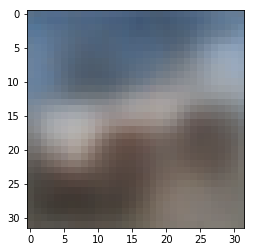

In [24]:
image = FT.to_pil_image(model.sample()[0].cpu())
image = t2np(image)
plt.imshow(image);